### EX05_CFPy_FloPy_ConduitWell

## CFPy - A Python package for pre- and postprocessing of the Conduit Flow Process for MODFLOW-2005 - Demonstration Example 05
- simple example for CFP mode 1 from the MODFLOW-CFP documentation, coupling `CFPy` (MODFLOW-CFP input-file generation) and `FloPy` (MODFLOW input-file generation)
- generating CFP input files from an user-defined node network structure
- usage of flow boundary conditions (FBC), e.g., wells in conduit network, flow limitation
- model computation with `cfpv2`

In [1]:
# run notebook with inline (non-interactive) plotting
# interactive mode only for special plots
%matplotlib inline

## 0.1 Import packages
In the first step, a number of necessary packages is importet. In case of failures you should install/update the packages through PIP

In [2]:
# Import necessary packages
# In case CFPy is not installed, move the `CFPy` package directory (the `CFPy` folder)
# to the example directory, which contains the Jupyter Notebook
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import os

import CFPy as cfpy
import flopy as flopy
path =""

## 0.2 Show Versions

In [3]:
%load_ext watermark

In [4]:
%watermark

Last updated: 2022-12-01T09:09:08.581051+01:00

Python implementation: CPython
Python version       : 3.8.5
IPython version      : 7.22.0

Compiler    : MSC v.1916 64 bit (AMD64)
OS          : Windows
Release     : 10
Machine     : AMD64
Processor   : Intel64 Family 6 Model 78 Stepping 3, GenuineIntel
CPU cores   : 4
Architecture: 64bit



In [5]:
%watermark --iversions

CFPy      : 1.0
flopy     : 3.3.3
pandas    : 1.2.1
matplotlib: 3.3.4
numpy     : 1.18.5



# 1. Creation of a Synthetic Karst System with CFP MODE1
## 1.1 Setup directories

In [6]:
# change active directory to model directory

if not os.path.exists(path):
    nb_dir = os.getcwd()
    path = os.path.join(nb_dir, "CFPy_EX05_RUN")
    if not os.path.exists(path):
        os.makedirs(path)

## 1.2 Create Basic MODFLOW Model (FloPy)

### Definition of Domain Characteristics

- **NOTE**
    - here we set up the `FloPy` model from the beginning, i.e., no pre-existing model is used
    - in the case where an existing `FloPy` model is used and CFP is added via `CFPy`, perform the following steps instead of setting up the `FloPy` model

- **Steps to extend an existing `FloPy` model with `CFPy`**:
    - assume an existing `FloPy` model `mf`
    - extract general discretization information via `mf.nrow_ncol_nlay_nper`
    - extract time discretization information via `mf.modeltime`
        - `mf.modeltime.nper` for number of stress periods
        - `mf.modeltime.nstp` for number of time steps
        - `mf.modeltime.perlen` for stress period length
        - `mf.modeltime.start_datetime` date / time of start
        - `mf.modeltime.steady_state` for steady-state flags of stress periods
        - `mf.modeltime.time_units` for the time unit flag
        - `mf.modeltime.totim` for total simulation time
        - `mf.modeltime.tslen` for time step length
        - `mf.modeltime.tsmult` for time step multiplier
        - see also https://flopy.readthedocs.io/en/3.3.5/source/flopy.modflow.mf.html and https://flopy.readthedocs.io/en/3.3.5/source/flopy.discretization.modeltime.html
    - extract model grid and layer elevation information via `mf.modelgrid`
        - `mf.modelgrid.top_botm` for cell-by-cell (i.e., an array of shape [nlay + 1, nrow, ncol]) elevation data
        - see also https://flopy.readthedocs.io/en/3.3.5/source/flopy.modflow.mf.html and https://flopy.readthedocs.io/en/3.3.5/source/flopy.discretization.structuredgrid.html

In [7]:
""" define model object """
os.chdir(path)
modelname = "CFPy_example_05"
# using the CFPv2 here, which does support CADS
# to change, type in the correct CFP version for exe_name
mf = flopy.modflow.Modflow(modelname, exe_name="cfpv2")

In [8]:
""" define general domain characteristics """
#NOTE: n_rows, n_cols, n_lays needs to be the same as specified in the .nbr-file!
#TODO: Use nrow, ncol etc. from FloPy also in CFPy

# matrix dimensions
# number of rows, columns, and layers in the domain, int
n_rows = 4
n_cols = 4
n_lays = 3
#width of each cell along rows/columns
delr = 10.
delc = 10.

""" hydraulic characteristics """
#horizontal and vertical hydraulic conductivity of the porous matrix [L/T]
hk = 1000.
vka = 200.
#specific storage [1/L] and specific yield [-]
ss = 0.00002
sy = 0.2

""" time discretization """
# define number of stress periods to be equal to the number of days in the recharge time series
n_pers = 5

# length (number of steps) of stress periods
# this variable assumes a uniform time discretization, i.e. all stress periods
# have the same number of time steps except the first stationary time step
perlen = 100

# number of time steps in each stress period (integer array)
n_stps = np.ones(n_pers) * 10.
n_stps = n_stps.tolist()
# ensure that fist stress period (stationary) has length 1
# n_stps[0] = 1.0

# list with "False" everywhere except 0th element (which is "True")
#     to specify steady state ("True") or transient ("False")
#     stress periods
steady = np.zeros(n_pers, dtype=np.bool)
# ensure stationary first stress period
# steady[0] = 1

#array of stress period numbers, 1-based indexing
spers = np.arange(1,n_pers + 1)

""" boundary conditions """
# matrix head on the left side (first column)
H_left = 20.
# head value for the constant head node
node_head_bc = 20.

## 1.3 Create CFP Input Files
- conduit network information
- *.nam-file of MODFLOW model gets updated at the end
- relevant CFP-files are created on the way

### 1.3.1 Conduit network information

In [9]:
""" create the network array """
# 1 = conduit node location, 0 = pure matrix cell without conduit node
network = np.array([
    [0., 0., 0., 0.],
    [0., 1., 0., 0.],
    [1., 1., 1., 1.],
    [0., 0., 0., 0.]
])

# generate elevations for the network
# uniform elevation of 4.5 m
elevations = np.ones_like(network) * 4.5

# generate MODFLOW layer elevation information
# here, single floats may be used if the layer elevations are uniform
layer_elevations = [[5.], [4.], [3.], [2.]]


Always visually check the validated network for structural correctness! 
			i.e., whether branches are correctly isolated or if they got connected during processing.


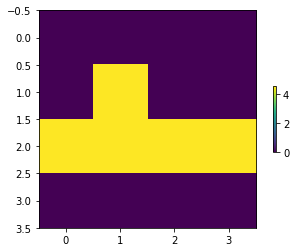

In [10]:
# validate the network
validator = cfpy.preprocessing.GeneralValidator(network=network, elevations=elevations)
valid_network = validator.validate_network()

""" generating the .nbr-file """
# we use the same layer elevations here as in the MODFLOW model

validator.generate_nbr(
    path = path,
    nrows = n_rows,
    ncols = n_cols,
    nlays = n_lays,
    nplanes = 1,
    layer_elevations = layer_elevations
)

# plot the network
# TODO Können wir hier das schöne Bild wie in EX_02 generieren?
im = plt.imshow(valid_network)
plt.colorbar(im, shrink=0.3)

### 1.3.2 CFPy - generate NBR input

In [11]:
""" initialize nbr module """

# NOTE: make sure there is only 1 .nbr-file in the active domain!!
# if no or multiple .nbr-files are present, CFPy throws an error

nbr = cfpy.nbr()

# read model layer/node and conduit layer/node elevations

# bot_elev has shape (n_layers, n_rows, n_cols)
# cond_elev has shape (n_conduit_layers, n_rows, n_cols)
# function looks for an .nbr-file, if none or more than one file is found, an error is raised
# make sure to only have one .nbr-file in the working directory
bot_elev, cond_elev = nbr.nbr_read()

# create nbr-data
nbr_data = nbr.nbr(bot_elev, cond_elev)

Elapsed time (.nbr file read): 0.0 s
Elapsed time (write nbr data): 0.0 s


In [12]:
# nbr-data contains:
#     0: node numbers
#     1: plane numbers
#     2: node locations
#     3: conduit locations
#     4: node neighbors
#     5: tube numbers
#     6: tube pairs
#     7: tube neighbors

# nbr data: locations in grid are indexed differently:
#     MODFLOW: (LAY, ROW, COL)
#     CFPy: (COL, ROW, LAY)

### 1.3.3 Plot Network

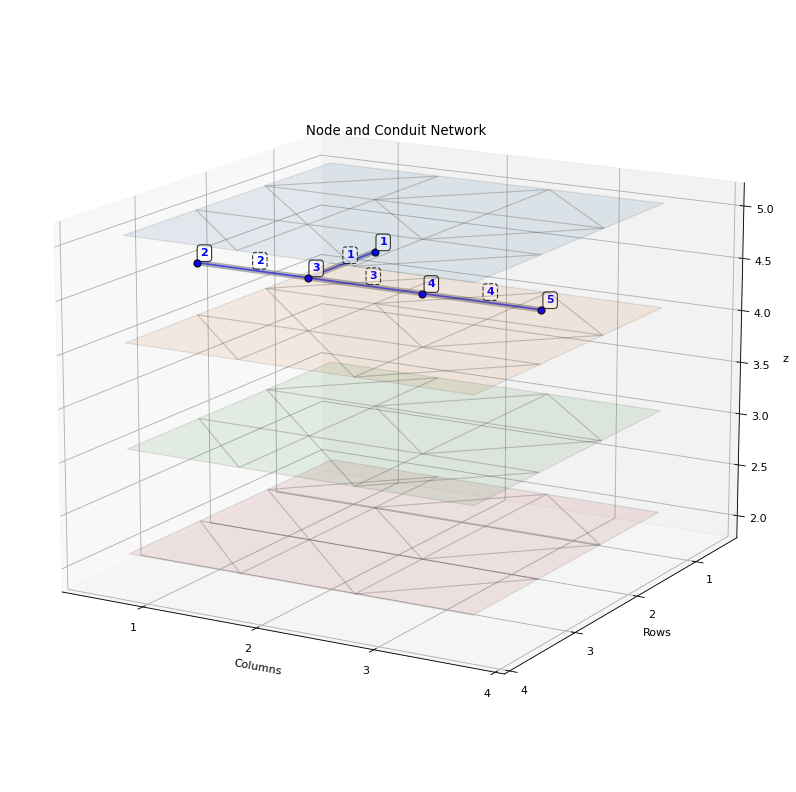

In [13]:
network = cfpy.plots.Network(elevs=[bot_elev, cond_elev], nbr_data=nbr_data)
plot = network.plot_network(text_shift=0.1, dpi=80, rot_x=15, rot_z=120, plot_nums=True, kind="triangular")
plt.savefig("network.jpg", dpi=600)

### 1.3.4 CFPy parametrization of conduits/CFP Mode 1

In [14]:
# make pipe parametrization lists

# get pipe numbers
p_num = nbr_data[5]

# parametrization of all k pipes
# assuming same characteristics for all pipes
# lists for all conduit parametrization can be accessed individually to make differently parametrized pipes
# e.g., p_diameter[13] = 0.45

# global parameters

DIA = 0.1
TOR = 1.0
KC  = 0.01
LRE = 10
HRE = 20

# diameter
p_diameter = np.ones(len(p_num)) * DIA
p_diameter = p_diameter.tolist()

# tortuosity
p_tortuosity = np.ones(len(p_num)) * TOR
p_tortuosity = p_tortuosity.tolist()

# roughness height
p_rheight = np.ones(len(p_num)) * KC
p_rheight = p_rheight.tolist()

# lower critical reynolds number
p_lcritrey = np.ones(len(p_num)) * LRE
p_lcritrey = p_lcritrey.tolist()

# higher critical reynolds number
p_hcritrey = np.ones(len(p_num)) * HRE
p_hcritrey = p_hcritrey.tolist()

# summarize all data in a 2D-array
pipe_data = [p_num, p_diameter, p_tortuosity, p_rheight, p_lcritrey, p_hcritrey]

In [15]:
# make lists for node head boundary conditions and tube-matrix exchange parameters

# get node numbers
n_num = nbr_data[0]

# parametrization for all n nodes
# if head > 0: fixed head
# if head == -1: calculated head
n_head = np.ones((len(n_num))) * -1
n_head = n_head.tolist()

# set individual node boundary conditions here
# e.g., for n_head[-1] the last node has a constant head given by the variable node_head_bc
# and for n_head[0] the first node has a constant head
n_head[1] = node_head_bc

# conduit wall conductivity in [m/d]
# identical for all conduits
# create list containing individual values to parametrize conduits individually
kex = 5.
k_exchange = np.ones((len(n_num))) * kex
k_exchange = k_exchange.tolist()

# summarize parametrization in lists
node_data = [n_num, n_head]
kex_data = [n_num, k_exchange]

In [16]:
# make FBC data
fbc_data = [(2, "FHLQ", 0.05), (4, "WELL", None)]

In [17]:
""" initialize CFP module """

# if CADS should not be used or standard CFP (CFPv1) is used set cads = None below!

cfp = cfpy.cfp(mode = 1, # mode 1 == conduits, 2 == preferential flow layer (not supported), 3 == both (not supported)
               nnodes = len(n_num), 
               npipes = len(p_num), 
               nlay = n_lays, 
               nbr_data = nbr_data, 
               geoheight = cond_elev, 
               sa_exchange = 1, 
               epsilon = 0.000001,
               niter = 100, 
               relax = 1., 
               p_nr = 1., 
               cond_data = pipe_data, 
               n_head = node_data, 
               k_exchange = kex_data, 
               ncl = 0, 
               cl = 0, 
               ltemp = 25.,
               condl_data = 0,
               cads = None,
               fbc = fbc_data)

# create list of strings
cfp = cfp.cfp()

C:\Users\Rudolph\Documents\GitHub\CFPy_TUD\CFPy_Examples\CFPy\cfp\cfp.py:266: UserWarning: When using a WELL FBC, make sure to include the BC values, i.e., flow rates, in the CRCH module!
  warnings.warn(msg)


### 1.3.5 CFPy - COC (conduit output control)

In [18]:
""" initialize COC module """

coc = cfpy.coc(nnodes = len(nbr_data[0]),
               node_numbers = nbr_data[0],
               n_nts = 1,
               npipes = len(nbr_data[5]), 
               pipe_numbers = nbr_data[5],
               t_nts = 1)

# create list of strings
coc = coc.coc()

### 1.3.6 CFPy - CRCH (conduit recharge)

In [19]:
""" initialize CRCH module """

# p_crch is list of length (n_nodes) specifying the direct recharge fraction for each node
# initially set p_crch to 0 for all nodes (no direct recharge)
p_crch = np.zeros((len(n_num))).tolist()

# input direct recharge fraction (0 <= p_crch <= 1) for individual nodes
p_crch[3] = 1.

# FBC data for WELL
fbc_well = [(4, -0.5)]

crch = cfpy.crch(iflag_crch = 1, 
                 nper = n_pers, 
                 node_numbers = nbr_data[0], 
                 p_crch = p_crch,
                 fbc_well = fbc_well)

# create list of strings
crch = crch.crch()

## 1.4 MODFLOW Input Files (FloPy)
### 1.4.1 DIS

In [20]:
""" DIS (Discretization): Creates model grid """

# Model grid:
# Note: MODFLOW defaults to units of m/day
# overall dimensions of domain (in x- and y-direction)
Lx = n_cols*delr
Ly = n_rows*delc
mtop = np.array(bot_elev[0][:][:])
mbot = np.array(bot_elev[1:][:][:])

# Create dis object:
dis = flopy.modflow.ModflowDis(mf, n_lays, n_rows, n_cols, n_pers, delr, delc, top=mtop, botm=mbot,
                               perlen=perlen, nstp=n_stps, steady=steady, itmuni=4, lenuni=2)

### 1.4.2 BAS

In [21]:
""" BAS6 (Basic): Assigns constant head boundaries """

# if ibound < 0: constant head, if = 0: inactive, if > 0: active.
# create arrays to indicate active cells (ibound) and starting heads (H_init)
# integer array of dim (z,y,x), makes all cells active 
ibound = np.ones((n_lays, n_rows, n_cols), dtype=np.int32)
# replace leftmost and rightmost columns with -1 to indicate constant head 
ibound[:,:,0] = -1

strt = np.ones_like(ibound) * H_left

bas = flopy.modflow.ModflowBas(mf, ibound=ibound, strt=strt)

### 1.4.3 LPF

In [22]:
""" LPF (Layer Property Flow): Assigns horizontal & vertical flow parameters between cells """
# Only one of either the BCF, LPF, or HUF2 packages should be used to control flow between cells
# Can also in this package set confined/unconfined (defaults to confined), cell-by-cell Ks as an array, 
# storage, specific yield, etc.
# defaults to confined

#0=confined, >0 = unconfined/convertible
laytyp = [1., 1., 1.]

lpf = flopy.modflow.ModflowLpf(mf, laytyp=laytyp, hk=hk, vka=vka, ss=ss, sy=sy) 

### 1.4.4 OC

In [23]:
""" OC (Output Control): Decides what outputs to save """
# create output control file using dictionary
oc = flopy.modflow.ModflowOc(mf)

### 1.4.5 PCG

In [24]:
""" PCG (Preconditioned Conjugate Gradient) """
pcg = flopy.modflow.ModflowPcg(mf, mxiter=20, iter1=10, ihcofadd=9999, relax=0.97, nbpol=2, iprpcg=5, mutpcg=0)

### 1.4.6 RCH

In [25]:
""" RCH: Recharge """
# recharge flux distributed over the top of the model - MODFLOW multiplies the fluxes by the horizontal area of the cells 
# to which they are applied to calculate the volumetric flux rates

# generate recharge data
rch_ts = np.array([0.003, 0.001, 0.002, 0.003, 0.002])

# flag, 1=rech only applied to top layer
nrchop = 1
# if non-zero, cell budget data will be saved
ipakcb = 50
# layer to which recharge is applied to (only used if nrchop=2)
irch = 1

# dictionary of recharge fluxes for each stress period
rech = {}
    
for num, rech_in in enumerate(rch_ts):
    
    # make array (n_rows x n_cols) to store cell-by-cell recharge information
    # apply recharge to all cells then apply direct recharge in relevant cells
    rech_data = np.ones((n_rows, n_cols)) * rech_in
    
    # direct recharge cells have to be given explicitly
    # such as
    # rech_data[ROW, COL] = some_direct_recharge
    
    rech[num] = rech_data

rch = flopy.modflow.mfrch.ModflowRch(mf, nrchop=nrchop, ipakcb=ipakcb, rech=rech, irch=irch)

# 2 Write input files and run the model

## 2.1 MODFLOW input

In [26]:
mf.write_input()

## 2.2 CFP Mode1 input

### 2.2.1 CFPy - write_input

In [27]:
""" initialize write_input module """

input_files = cfpy.write_input(modelname = modelname,
                               data_strings = [coc, crch, cfp],
                               file_extensions = ['coc', 'crch', 'cfp'])

# write CFP input files
input_files.write_input()

### 2.2.2 CFPy - update_nam

In [28]:
""" initialize update_nam module """

nam = cfpy.update_nam(modelname = modelname,
                      mode = 1,
                      cfp_unit_num = 52,
                      crch_unit_num = 53,
                      coc_unit_num = 54)

# update existing .nam file
nam.update_nam()

# 3 Run MODFLOW-2005 CFP

In [29]:
success, buff = mf.run_model(silent=True)

# 4 Post-Processing

## 4.1 Process information for the MODFLOW continuum

In [30]:
""" FloPy utilities for matrix information """

# load data
import flopy.utils.binaryfile as bf

# get cell head information
# choose location to measure heads (lay,row,col), zero-based indexing
obs_loc = (0,1,2)

# read the list, binary files
lst = flopy.utils.MfListBudget(modelname+'.list')
hds = bf.HeadFile(modelname+'.hds')
# return a list of head and budget print times
h_times = hds.get_times()
b_times = lst.get_times()

heads = []
for t in h_times:
    heads.append(hds.get_data(totim=t))
heads = np.asarray(heads)

budgets = []
for t in b_times:
    budgets.append(lst.get_data(totim=t, incremental=True))

# get a time series of heads at a specific location
obs_ts = hds.get_ts(obs_loc)

## 4.2 Process information for CFP Mode1

In [31]:
""" CFPy utilities for node and tube related data """

fr = cfpy.postprocessing.FileReader(
    modelname=modelname
)

node_data, tube_data = [], []

node_nums = [1, 2, 3, 5]
tube_nums = [1, 2, 3, 4]

for node in node_nums:
    node_df, tube_df = fr.read_output(node_num=node, tube_num=None)
    node_data.append(node_df)
    
for tube in tube_nums:
    node_df, tube_df = fr.read_output(node_num=None, tube_num=tube)
    tube_data.append(tube_df)

In [32]:
""" look at imported node time series data """
node_data[1].head()

,Node#,Node Head [L],Matrix Head [L],Exchange [L3 T-1],CADS Flow [L3 T-1],PFPS Flow [L3 T-1],Direct Recharge [L3 T-1],Q Well [L3 T-1],FHLQ,Cauchy,Cauchy LQ,QLH,Q Fix [L3 T-1]
0,2,20.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.015312
1,2,20.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.015312
2,2,20.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.015312
3,2,20.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.015312
4,2,20.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.015311


In [33]:
""" look at imported tube time series data """
tube_data[0].head()

,Tube,Beginning Node#,Ending Node#,Flow Type,Q [L3 T-1],Diam. [L],Len. [L],Re [-],Residence Time [T]
0,1,1,3,LAMI.,0.0211,0.1,10.0,3.48200,3.72180
1,1,1,3,LAMI.,0.0211,0.1,10.0,3.48200,3.72180
2,1,1,3,LAMI.,0.0211,0.1,10.0,3.48201,3.72179
3,1,1,3,LAMI.,0.0211,0.1,10.0,3.48201,3.72179
4,1,1,3,LAMI.,0.0211,0.1,10.0,3.48201,3.72179


## 4.3 Generate plots for visualization

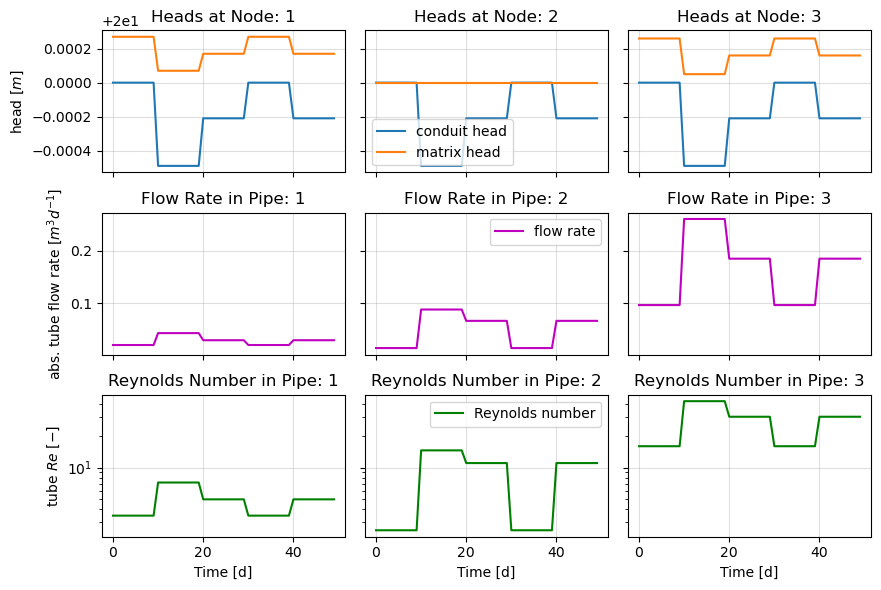

In [34]:
""" Generate some plots (time series information) """

fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(9, 6), dpi=100, sharex="col", sharey="row")

for i in range(3):
    ax[0, i].plot(node_data[i].index, node_data[i].iloc[:, 1], label="conduit head")
    ax[0, i].plot(node_data[i].index, node_data[i].iloc[:, 2], label="matrix head")
    ax[0, i].set_title("Heads at Node: {}".format(node_nums[i]))
    ax[0, i].grid(True, alpha=0.4)
    
    ax[1, i].plot(tube_data[i].index, np.abs(tube_data[i].iloc[:, 4]), label="flow rate", c="m")
    ax[1, i].set_title("Flow Rate in Pipe: {}".format(tube_nums[i]))
    ax[1, i].grid(True, alpha=0.4)
    
    ax[2, i].plot(tube_data[i].index, tube_data[i].iloc[:, 7], label="Reynolds number", c="green")
    ax[2, i].set_yscale("log")
    ax[2, i].set_title("Reynolds Number in Pipe: {}".format(tube_nums[i]))
    ax[2, i].grid(True, alpha=0.4)
    
ax[0, 0].set_ylabel("head [$ m $]")
ax[0, 1].legend(loc="best")

ax[1, 0].set_ylabel("abs. tube flow rate [$ m^3 d^{-1} $]")
ax[1, 1].legend(loc="best")

ax[2, 0].set_ylabel("tube $ Re $ [$ - $]")
ax[2, 1].legend(loc="best")

ax[2, 0].set_xlabel("Time [d]")
ax[2, 1].set_xlabel("Time [d]")
ax[2, 2].set_xlabel("Time [d]")

plt.tight_layout()
plt.savefig("results_ts.png", dpi=600)

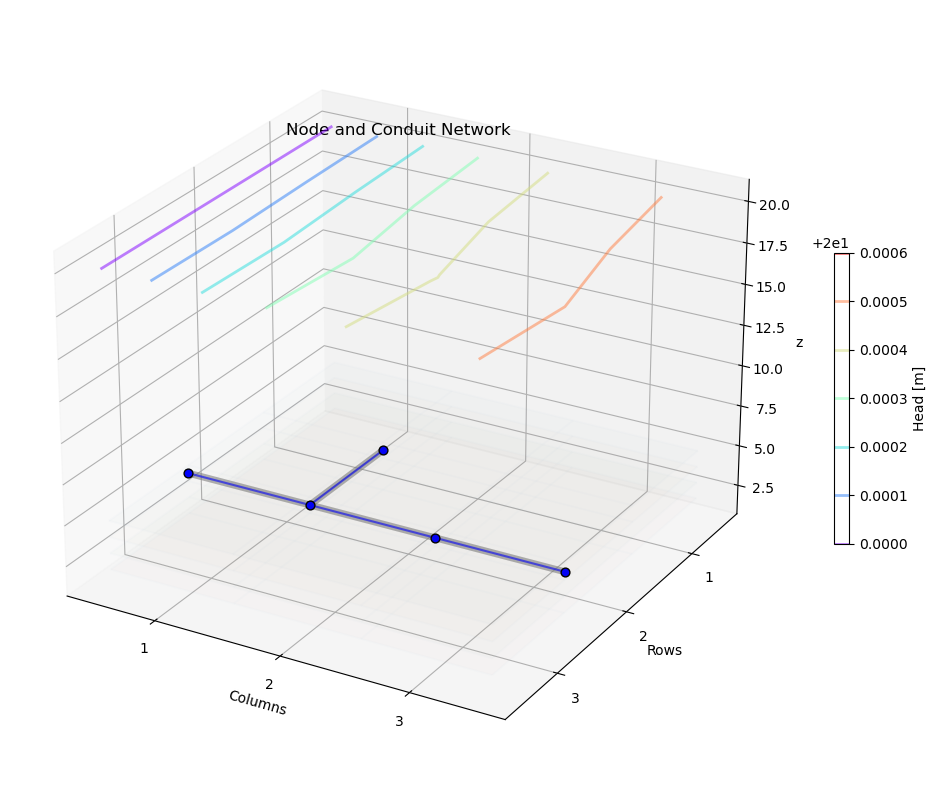

In [35]:
""" Generate more plots (spatially distributed information) """
network = cfpy.plots.Network(elevs=[bot_elev, cond_elev], nbr_data=nbr_data)
plot = network.plot_results(heads=heads, time=0, layer=0, text_shift=0.1, dpi=100, rot_x=25, rot_z=120, plot_nums=False, n_contours=5, alpha=0.01)
plt.savefig("results_network.png", dpi=600)

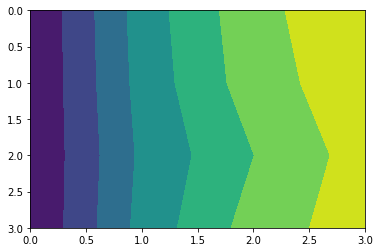

In [36]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 4))

im = ax.contourf(heads[0, 0, :, :])
# ax.set_xlim(-0.5, 3.5)
# ax.set_ylim(-0.5, 3.5)
# ax.set_yticks([3, 2, 1, 0])
# ax.set_xticks([0, 1, 2, 3])
ax.invert_yaxis()